# Introduction

Current notebook presents a full study of partial defect classification based on passive gamma spectroscopy measurements. The notebook walks through how one can obtain the (idealized) peak counts-per-volume from Serpent burnup results, feign geometric efficiency results and Serpent2 detector efficiency results. Finally the peak counts are analyzed with multi variate analysis methods (MVA).

The structure of the notebook is the following:

1. The fuel library from (http://dx.doi.org/10.17632/8z3smmw63p.1) is loaded, and 200 UO2 inventories are sampled.
2. The inventories are interfaced to XCOM and the attenuation files of each are created.
3. The feign calculations are set up
4. The detector efficiency is fitted
5. The concentrations from the inventory is turned into spectrum peaks by multiplying with the response functions.
6. The MVA is carried out.
    
The following imports are needed (in order to install feign, visit https://github.com/ezsolti/feign). The `MVAfunctions` module contains functions needed for steps 2-6.

In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import os
import random
from sklearn import preprocessing
from sklearn import decomposition

from MVAfunctions import *


from feign.geometry import *
from feign.blocks import *

path=os.getcwd()
fuelLibraryPath = '/home/zsolt/Documents/useful_misc/MVA_Data/UU_PWR_UOX-MOX.csv'
xcomPath = '/home/zsolt/Documents/FEIGN/XCOM/'

N=200 #number of random samples
samplefile='sample200.csv'

reRun=os.path.isfile(samplefile) #if the csv already exists, we consider that only the MVA is to be done, so feign will not run

# Sample the fuel library

We import a random sample of UOX inventories from the csv file. The first 789406 entries of the file are the UOX samples.

This bit of code might be slightly confusing, since we are reading the csv twice. The reason is, that we could read in just a random amount of lines (such as with the commented code), however we also would like to have a condition of having CT<=30y, BU>=20MWd/kgU and only UOX fuel. 
We could also read in everything from the csv, and then use conditions and sample it, but there would be a point in time when we would require a huge amount of data in memory. Therefore, first only three columns of the library (BU, CT and fuelType) is being read, then we are going to use conditional indexing, take a random sample of the available indexes, and read in only the selected rows from the csv file.

Note: somewhere over the way pandas cannot identify my own id column anymore, and creates its own, while renames mine as 'Unnamed: 0', I will refer to that column with this key. 


In [3]:
if not reRun:
    #read only 3 columns of the file
    fl=pd.read_csv(fuelLibraryPath, header = 0, usecols=['BU','CT','fuelType'])

    #select the rows which follow our conditions
    fl=fl[(fl["BU"]>= 20) & (fl["CT"]<= 30*365) & (fl["fuelType"] == 'UOX')]

    #take 200 random sample of the indices
    #since pd.read_csv only has a skiprows option, we have to create a list of indices to be skipped
    noskip=random.sample(list(fl.index+1),N) #+1 because the header is the 0th row
    skip=[i for i in range(1,1321398) if i not in noskip]

    #read only the rows we are interested in
    fl = pd.read_csv(fuelLibraryPath, header=0, skiprows=skip)

    fl.to_csv(samplefile)
else:
    fl=pd.read_csv('sample200.csv', index_col=0)
    fl.rename(columns={'Unnamed: 0.1': 'Unnamed: 0'},inplace=True) #upon writing the file the first column is renamed, I take care of it.

# Attenuation coefficient for samples

In this section we are going to interface the inventories with the XCOM program. The program is available at https://physics.nist.gov/PhysRefData/Xcom/Text/download.html. This code needs to be compiled on the computer where this notebook is run, if not a previously created sample file and previosly calculated geometric efficiencies are used.

Above we have already given the path to the executable along with the imports of some helper functions to facilitate interfacing.

What is done here is to convert the atomic concentrations from the csv into weight percentage and running XCOM to generate the attenuation coefficients.

(Some notes on this are given at https://ezsolti.github.io/scripts/2018/05/27/xcominput.html)

In [4]:
if not reRun:
    for i,row in fl.iterrows():
        massconcdic=AtConc_to_ZWeightPer(row)

        #TODO energy lines into string!
        xcomfuelstr = XCOMmaterial(massconcdic)

        xcomstr="'spentfuel\n4\n"+str(len(massconcdic))+"\n"+xcomfuelstr+"1\n3\n1\n34\n4.971E-01\n5.63E-01\n5.69E-01\n6.006E-01\n6.04E-01\n6.103E-01\n6.21E-01\n6.35E-01\n6.62E-01\n7.23E-01\n7.24E-01\n7.56E-01\n7.57E-01\n7.65E-01\n7.95E-01\n8.01E-01\n8.73E-01\n9.96E-01\n1.004E+00\n1.038E+00\n1.05E+00\n1.167E+00\n1.205E+00\n1.246E+00\n1.274E+00\n1.365E+00\n1.494E+00\n1.562E+00\n1.596E+00\n1.766E+00\n1.797E+00\n1.988E+00\n2.112E+00\n2.185E+00\nN\nspentfuelMu%d.dat\n1\n'"%row['Unnamed: 0']

        path=os.getcwd()
        os.chdir('/home/zsolt/Documents/FEIGN/XCOM/') #TODO use the path since given
        os.system('printf '+xcomstr+' | ./XCOMtest')
        os.chdir(path)  

# Geometric efficiency

Current section describes a feign input for a passive gamma setup around a 17x17 PWR fuel assembly. feign is run for fuel assemblies with containing fresh or spent material, and also for intact fuel and for fuel with partial defects. The two outer loops handle these.

In the following I put all the input objects into one cell, because I will need to loop through it. However the proper description of different objects can be found in the example https://ezsolti.github.io/feign/ex3_17x17PWR_at_Clab.html. Slight difference here is that four detectors are defined (with collimators and absorbers). The reason for this is, because we want to obtain an average geometric efficiency over these four detectors (of course this only plays a role for assymmetric assembly arrangements).

### NOTE

Here the absorbers are included within the feign calculation. However for the continuation of this work it might be a better idea to include the absorbers within the detector efficiency calculation, in this way scattered photons can contribute to the peaks.

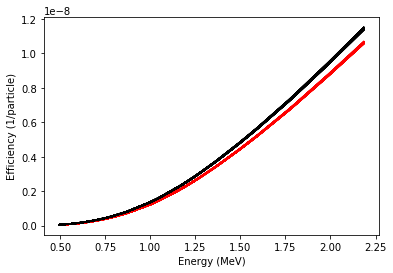

In [5]:
plt.figure()
cases=['O','R']
for c in cases:
    for fuelinv in list(fl['Unnamed: 0'])+['orig']:

        ###########################
        #
        # Setting materials
        #
        ###########################
        if fuelinv=='orig':
            uo2=Material('1')
            uo2.set_density(10.5)
            uo2.set_path(('/data/UO2.dat',1))
        else:
            uo2=Material('1')
            uo2.set_density(10.5)
            uo2.set_path(('/home/zsolt/Documents/FEIGN/XCOM/spentfuelMu%d.dat'%fuelinv,6))

        he=Material('2')
        he.set_density(0.00561781)
        he.set_path(('/data/He.dat',1))

        zr=Material('3')
        zr.set_density(6.52)
        zr.set_path(('/data/Zr.dat',1))

        h2o=Material('4')
        h2o.set_density(1.0)
        h2o.set_path(('/data/H2O.dat',1))

        ss=Material('5')
        ss.set_density(8.02)
        ss.set_path(('/data/SS.dat',1))

        air=Material('6')
        air.set_density(0.001225)
        air.set_path(('/data/Air.dat',1))

        lead=Material('7')
        lead.set_density(11.34)
        lead.set_path(('/data/Pb.dat',1))

        copper=Material('8')
        copper.set_density(8.96)
        copper.set_path(('/data/Cu.dat',1))

        alu=Material('9')
        alu.set_density(2.7)
        alu.set_path(('/data/Al.dat',1))

        ###########################
        #
        # Setting pin types
        #
        ###########################

        fuel=Pin('1')
        fuel.add_region(uo2,0.41)
        fuel.add_region(he,0.42)
        fuel.add_region(zr,0.48)

        dummy=Pin('2')
        dummy.add_region(ss,0.48)

        rodguide=Pin('3')
        rodguide.add_region(h2o,0.42)
        rodguide.add_region(zr,0.48)    

        ###########################
        #
        # Setting fuelmap and Assembly TODO: loop through fuelmaps.
        #
        ###########################

        pwrOrig=Assembly(17,17)
        pwrOrig.set_pitch(1.26)
        pwrOrig.set_source(uo2)
        pwrOrig.set_coolant(h2o)
        pwrOrig.set_surrounding(air)
        pwrOrig.set_pins(fuel,rodguide,dummy)

        fuelmap = AssemblyMap(c)

        pwrOrig.set_fuelmap(fuelmap)
        pool=Rectangle(Point(55, 55),Point(55, -55),Point(-55, -55),Point(-55, 55)).rotate(45)
        pwrOrig.set_pool(pool)

        ###########################
        #
        # Setting detectors and collimators
        #
        ###########################

        det1=Detector('D1')
        det1.set_location(Point(174.726, 174.726))

        det2=Detector('D2')
        det2.set_location(Point(174.726, 174.726).rotate(90))

        det3=Detector('D3')
        det3.set_location(Point(174.726, 174.726).rotate(180))

        det4=Detector('D4')
        det4.set_location(Point(174.726, 174.726).rotate(270))


        coll1=Collimator('collD1')
        coll1.set_back(Segment(Point(125.0,-11.6),Point(125.0,11.6)).rotate(45))
        coll1.set_front(Segment(Point(243.0,-4.1),Point(243.0,4.1)).rotate(45))
        det1.set_collimator(coll1)

        coll2=Collimator('collD2')
        coll2.set_back(Segment(Point(125.0,-11.6),Point(125.0,11.6)).rotate(45+90))
        coll2.set_front(Segment(Point(243.0,-4.1),Point(243.0,4.1)).rotate(45+90))
        det2.set_collimator(coll2)

        coll3=Collimator('collD3')
        coll3.set_back(Segment(Point(125.0,-11.6),Point(125.0,11.6)).rotate(45+180))
        coll3.set_front(Segment(Point(243.0,-4.1),Point(243.0,4.1)).rotate(45+180))
        det3.set_collimator(coll3)

        coll4=Collimator('collD4')
        coll4.set_back(Segment(Point(125.0,-11.6),Point(125.0,11.6)).rotate(45+270))
        coll4.set_front(Segment(Point(243.0,-4.1),Point(243.0,4.1)).rotate(45+270))
        det4.set_collimator(coll4)

        ###########################
        #
        # Setting absorber sheets (note, probably a "like but" solution should be implemented
        #
        ###########################

        steelwindow1=Absorber('steelwindow1')
        steelwindow1.set_form(Rectangle(Point(55.0,-30),Point(55.0,30),Point(55.5,30),Point(55.5,-30)).rotate(45))
        steelwindow1.set_material(ss)
        steelwindow1.set_accommat(air)

        steelwindow2=Absorber('steelwindow2')
        steelwindow2.set_form(Rectangle(Point(55.0,-30),Point(55.0,30),Point(55.5,30),Point(55.5,-30)).rotate(45+90))
        steelwindow2.set_material(ss)
        steelwindow2.set_accommat(air)

        steelwindow3=Absorber('steelwindow3')
        steelwindow3.set_form(Rectangle(Point(55.0,-30),Point(55.0,30),Point(55.5,30),Point(55.5,-30)).rotate(45+180))
        steelwindow3.set_material(ss)
        steelwindow3.set_accommat(air)

        steelwindow4=Absorber('steelwindow4')
        steelwindow4.set_form(Rectangle(Point(55.0,-30),Point(55.0,30),Point(55.5,30),Point(55.5,-30)).rotate(45+270))
        steelwindow4.set_material(ss)
        steelwindow4.set_accommat(air)

        copper1mm1=Absorber('copper1mm1')
        copper1mm1.set_form(Rectangle(Point(243.7, -40.0),Point(243.7, 40.0),Point(243.8,40),Point(243.8,-40)).rotate(45))
        copper1mm1.set_material(copper)
        copper1mm1.set_accommat(air)

        copper1mm2=Absorber('copper1mm2')
        copper1mm2.set_form(Rectangle(Point(243.7, -40.0),Point(243.7, 40.0),Point(243.8,40),Point(243.8,-40)).rotate(45+90))
        copper1mm2.set_material(copper)
        copper1mm2.set_accommat(air)

        copper1mm3=Absorber('copper1mm3')
        copper1mm3.set_form(Rectangle(Point(243.7, -40.0),Point(243.7, 40.0),Point(243.8,40),Point(243.8,-40)).rotate(45+180))
        copper1mm3.set_material(copper)
        copper1mm3.set_accommat(air)

        copper1mm4=Absorber('copper1mm4')
        copper1mm4.set_form(Rectangle(Point(243.7, -40.0),Point(243.7, 40.0),Point(243.8,40),Point(243.8,-40)).rotate(45+270))
        copper1mm4.set_material(copper)
        copper1mm4.set_accommat(air)


        steel21mm1=Absorber('steel21mm1')
        steel21mm1.set_form(Rectangle(Point(243.8,-40),Point(243.8,40),Point(245.9,40),Point(245.9,-40)).rotate(45))
        steel21mm1.set_material(ss)
        steel21mm1.set_accommat(air)

        steel21mm2=Absorber('steel21mm2')
        steel21mm2.set_form(Rectangle(Point(243.8,-40),Point(243.8,40),Point(245.9,40),Point(245.9,-40)).rotate(45+90))
        steel21mm2.set_material(ss)
        steel21mm2.set_accommat(air)

        steel21mm3=Absorber('steel21mm3')
        steel21mm3.set_form(Rectangle(Point(243.8,-40),Point(243.8,40),Point(245.9,40),Point(245.9,-40)).rotate(45+180))
        steel21mm3.set_material(ss)
        steel21mm3.set_accommat(air)

        steel21mm4=Absorber('steel21mm4')
        steel21mm4.set_form(Rectangle(Point(243.8,-40),Point(243.8,40),Point(245.9,40),Point(245.9,-40)).rotate(45+270))
        steel21mm4.set_material(ss)
        steel21mm4.set_accommat(air)

        alu3mm1=Absorber('alu3mm1')
        alu3mm1.set_form(Rectangle(Point(245.9,-40),Point(245.9,40),Point(246.2,40),Point(246.2,-40)).rotate(45))
        alu3mm1.set_material(alu)
        alu3mm1.set_accommat(air)

        alu3mm2=Absorber('alu3mm2')
        alu3mm2.set_form(Rectangle(Point(245.9,-40),Point(245.9,40),Point(246.2,40),Point(246.2,-40)).rotate(45+90))
        alu3mm2.set_material(alu)
        alu3mm2.set_accommat(air)

        alu3mm3=Absorber('alu3mm3')
        alu3mm3.set_form(Rectangle(Point(245.9,-40),Point(245.9,40),Point(246.2,40),Point(246.2,-40)).rotate(45+180))
        alu3mm3.set_material(alu)
        alu3mm3.set_accommat(air)

        alu3mm4=Absorber('alu3mm4')
        alu3mm4.set_form(Rectangle(Point(245.9,-40),Point(245.9,40),Point(246.2,40),Point(246.2,-40)).rotate(45+270))
        alu3mm4.set_material(alu)
        alu3mm4.set_accommat(air)

        lead8mm1=Absorber('lead8mm1')
        lead8mm1.set_form(Rectangle(Point(246.2,-40),Point(246.2,40),Point(247.0,40),Point(247.0,-40)).rotate(45))
        lead8mm1.set_material(lead)
        lead8mm1.set_accommat(air)

        lead8mm2=Absorber('lead8mm2')
        lead8mm2.set_form(Rectangle(Point(246.2,-40),Point(246.2,40),Point(247.0,40),Point(247.0,-40)).rotate(45+90))
        lead8mm2.set_material(lead)
        lead8mm2.set_accommat(air)

        lead8mm3=Absorber('lead8mm3')
        lead8mm3.set_form(Rectangle(Point(246.2,-40),Point(246.2,40),Point(247.0,40),Point(247.0,-40)).rotate(45+180))
        lead8mm3.set_material(lead)
        lead8mm3.set_accommat(air)

        lead8mm4=Absorber('lead8mm4')
        lead8mm4.set_form(Rectangle(Point(246.2,-40),Point(246.2,40),Point(247.0,40),Point(247.0,-40)).rotate(45+270))
        lead8mm4.set_material(lead)
        lead8mm4.set_accommat(air)

        ###########################
        #
        # Setting the experiment
        #
        ###########################

        ex=Experiment()
        ex.set_random(10)
        ex.set_assembly(pwrOrig)
        ex.set_detectors(det1,det2,det3,det4)
        ex.set_materials(uo2,he,zr,h2o,air,lead,alu,copper,ss)
        ex.set_absorbers(steelwindow1,steelwindow2,steelwindow3,steelwindow4,
                         lead8mm1,lead8mm2,lead8mm3,lead8mm4,
                         steel21mm1,steel21mm2,steel21mm3,steel21mm4,
                         alu3mm1,alu3mm2,alu3mm3,alu3mm4,
                         copper1mm1,copper1mm2,copper1mm3,copper1mm4)

        elines=['0.4971',
         '0.563',
         '0.569',
         '0.6006',
         '0.604',
         '0.6103',
         '0.621',
         '0.635',
         '0.662',
         '0.723',
         '0.724',
         '0.756',
         '0.757',
         '0.765',
         '0.795',
         '0.801',
         '0.873',
         '0.996',
         '1.004',
         '1.038',
         '1.05',
         '1.167',
         '1.205',
         '1.246',
         '1.274',
         '1.365',
         '1.494',
         '1.562',
         '1.596',
         '1.766',
         '1.797',
         '1.988',
         '2.112',
         '2.185']
        ex.set_elines(elines)

        ###########################
        #
        # Plotting (optional) and running the experiment
        #
        ###########################

        ex.set_output('outs/geomEff_%s_%s.dat'%(c,str(fuelinv)))
        if not reRun:
            ex.Run()
            plt.errorbar(ex.elines,ex.geomEffAve,3*ex.geomEffAveErr,label=c+', ' + str(fuelinv))
        else:
            engeff=np.loadtxt('outs/geomEff_%s_%s.dat'%(c,str(fuelinv)))
            if c=='O':
                plt.plot(engeff[:,0],engeff[:,1],'r')
            else:
                plt.plot(engeff[:,0],engeff[:,1],'k')

plt.xlabel('Energy (MeV)')
plt.ylabel('Efficiency (1/particle)')
plt.show()

## Example for plotting the geometry

Let us plot the geometry outside of the loop to avoid plotting it for each case.

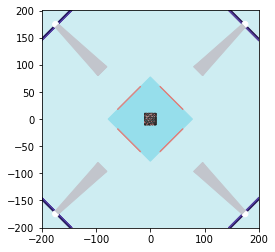

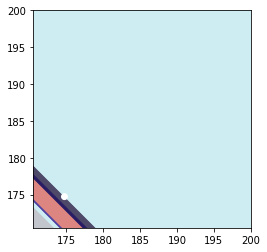

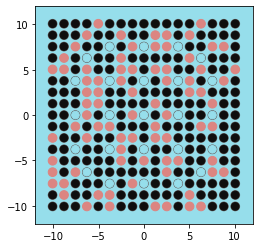

In [5]:
uo2.set_color("#0f0e0e")
he.set_color("#474545")
zr.set_color("#635f5f")
h2o.set_color("#96deeb")
air.set_color("#ceedf2")
lead.set_color("#4e4869")
alu.set_color("#281b63")
copper.set_color("#5240a1")
ss.set_color("#dc8581")#("#3c3266")
ex.Plot(xl=[-200.5,200.5],yl=[-200.5,200.5],detectorSize=5.4)#,out='gammasetup.png', dpi=200)
ex.Plot(xl=[170.5,200],yl=[170.5,200],detectorSize=0.4)
ex.Plot(xl=[-12,12],yl=[-12,12],detectorSize=0.4)#,out='assemblypd.png', dpi=200)

# Detector efficiency curve

In order to obtain this, I have run a simple HPGE model and calculated the pulse height spectrum for various source energies. Then I have fitted a curve on the energy vs peak height. Details on  this are given at https://github.com/ezsolti/PartialDefect/tree/master/detectorEfficiency. The fitted function is to be found in the `MVAfunctions` module imported in the beginning of this notebook.

### Note

This efficiency curve is based on a pen beam source, hitting the detector. It is a good approximation for this first part. However when trying to create the absolute values for the continuation of this work, it might need to be modified. For that, one will need to define a surface source (with the slit size), and some angle distribution of the gammas. Similarly, as said earlier, the absorbers should be handled already in that model and not in the feign calculations, in order to take into account scattering.


# PCA of data

The final section of this notebook is to multiply the activities with the efficiencies and do a PCA to see the impacts of having all lines vs only Eu lines. Also of having inventory-dependent attenuation coefficients.

First of all, I will assume that at this point the csv is not necessarily kept in memory, and sometimes i will want to rerun only the analysis, not the whole geometric efficiency calculation. For this reason I will read the previously saved new csv file, and rename its 'id' column.

In [7]:
if reRun: #I reread again, because I want to rename the first column.
    fl=pd.read_csv('sample200.csv', index_col=0)
    fl.rename(columns={'Unnamed: 0.1': 'id'},inplace=True)

Then, I will need a helper function to convert the concentrations to gamma line frequencies. This is done in the gammaLines function of the MVAfunctions module.

However, the  preparation of the data matrix for the MVA is abstracted away into a `prepareX` function available in the `MVAfunctions` module. This builds the feautre matrix and the label vector. It also creates a list which will store all the energies in the order how it is used in the columns of the data matrix. This list will be used later to print the energy line for feature selection. This function makes use of the above mentioned gammaLines function.

In [8]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Cs137','Cs134','Eu154'],scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)

## Feature ranking

Here we rank the features to see how impoartant they are to predict the various cases. One can play around to see how scaling and normalization might affect the feature ranking.

### Common peak to label correlation

The whole motivaiton of the work is to show that the ratios of peaks are affected by the different cases, so it is not very meaningful to see a single peak's correlation. Nevertheless, these are normalized peaks, so it has some relevance.

In [10]:
###Get correlation scores 
y=labels
corrs=[]
for i in range(data.shape[1]):
    xi=data[:,i]
    xiy=xi*y
    covi=np.mean(xiy)-np.mean(xi)*np.mean(y)
    corri=covi/(np.std(xi)*np.std(y))
    corrs.append(corri*100)

inds = (-np.abs(np.array(corrs))).argsort()

for en, corr, i in zip(energies[inds],np.array(corrs)[inds], inds):
    print(en,'\t', '%.2f'%abs(corr))

Eu154: 1.596 	 9.55
Eu154: 1.494 	 9.21
Eu154: 1.274 	 7.95
Eu154: 1.246 	 7.73
Eu154: 1.004 	 4.99
Eu154: 0.996 	 4.88
Eu154: 0.873 	 2.92
Cs134: 1.365 	 2.28
Cs134: 1.167 	 1.81
Cs134: 0.563 	 1.44
Cs134: 0.569 	 1.39
Cs134: 1.038 	 1.37
Cs134: 0.604 	 1.10
Cs137: 0.662 	 0.85
Eu154: 0.756 	 0.62
Cs134: 0.801 	 0.24
Cs134: 0.795 	 0.21
Eu154: 0.723 	 0.12


### Peak ratio to label correlation

Let's see how pairwise ratios correlate to the label. For this we have to create a new data matrix, where we set ratio to True, and switch of the scaling and the normalization (which would obscure the impact of taking the ratios)

In [11]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Cs137','Cs134','Eu154'],ratio=True,scaling=False,normalization=False,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)
y=labels
corrs=[]
for i in range(data.shape[1]):
    xi=data[:,i]
    xiy=xi*y
    covi=np.mean(xiy)-np.mean(xi)*np.mean(y)
    corri=covi/(np.std(xi)*np.std(y))
    corrs.append(corri*100)

inds = (-np.abs(np.array(corrs))).argsort()

for en, corr, i in zip(energies[inds],np.array(corrs)[inds], inds):
    print(en,'\t', '%.2f'%abs(corr))

Eu154: 1.246 / Eu154: 1.494 	 99.35
Eu154: 1.274 / Eu154: 1.494 	 99.34
Cs134: 1.167 / Cs134: 1.365 	 99.33
Eu154: 1.246 / Eu154: 1.596 	 99.33
Eu154: 1.274 / Eu154: 1.596 	 99.32
Cs134: 1.038 / Cs134: 1.365 	 99.30
Eu154: 1.004 / Eu154: 1.494 	 99.29
Eu154: 0.756 / Eu154: 1.494 	 99.29
Eu154: 1.004 / Eu154: 1.596 	 99.28
Eu154: 0.996 / Eu154: 1.494 	 99.28
Eu154: 0.996 / Eu154: 1.596 	 99.28
Eu154: 1.004 / Eu154: 1.274 	 99.26
Eu154: 0.996 / Eu154: 1.274 	 99.25
Cs134: 1.038 / Cs134: 1.167 	 99.25
Eu154: 1.004 / Eu154: 1.246 	 99.25
Eu154: 0.996 / Eu154: 1.246 	 99.24
Eu154: 0.873 / Eu154: 1.596 	 99.20
Eu154: 0.873 / Eu154: 1.494 	 99.19
Eu154: 0.873 / Eu154: 1.274 	 99.16
Eu154: 1.246 / Eu154: 1.274 	 99.15
Eu154: 0.873 / Eu154: 1.246 	 99.14
Eu154: 1.494 / Eu154: 1.596 	 99.14
Cs134: 0.801 / Cs134: 1.365 	 99.11
Cs134: 0.795 / Cs134: 1.365 	 99.08
Eu154: 0.756 / Eu154: 1.596 	 99.08
Cs134: 0.801 / Cs134: 1.167 	 99.02
Eu154: 0.756 / Eu154: 1.274 	 99.01
Cs134: 0.795 / Cs134: 1.167 

## PCA

Here comes the actual principal component analysis. We will first include the energy lines of both Cs137, Cs134 and Eu154, and then we eliminate the features.

First we assign colors to the classes for the plotting.

In [12]:
colors=['red','green']
leg=['O','R']
import matplotlib.patches as mpatches
recs = []
for i in range(0,len(colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors[i]))

### Both Cs137, Cs134 and Eu154

With using inventory specific attenuation coefficients.

We will see that the first two PC is dominated by the BU and CT. 

In [13]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Cs137','Cs134','Eu154'],ratio=False,scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)

#### 2D PCA

In [14]:
pca = decomposition.PCA(n_components=2)
pca.fit(data)
datat = pca.transform(data)

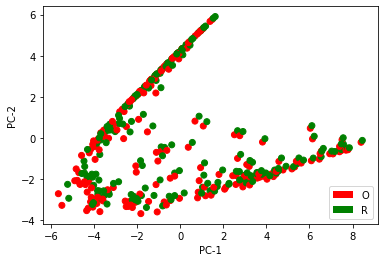

In [15]:
plt.figure()
plt.scatter(datat[:,0],datat[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PC-1')

plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.show()

#### 3D PCA

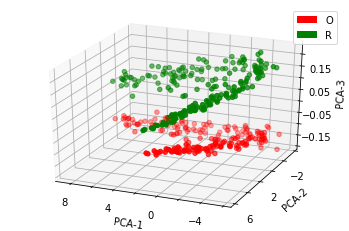

In [16]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
pca = decomposition.PCA(n_components=3)
pca.fit(data)
datat3 = pca.transform(data)
fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(datat3[:,0],datat3[:,1],datat3[:,2],c=labels, cmap=matplotlib.colors.ListedColormap(colors))
ax.legend(recs,leg,loc=1)
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
ax.set_zlabel('PCA-3')
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
[l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % 2 != 0]
[l.set_visible(False) for (i,l) in enumerate(ax.zaxis.get_ticklabels()) if i % 2 != 0]
ax.azim = 113
ax.elev = 28


plt.show()

#### Article plot

Where the colouring indicates CT as well.

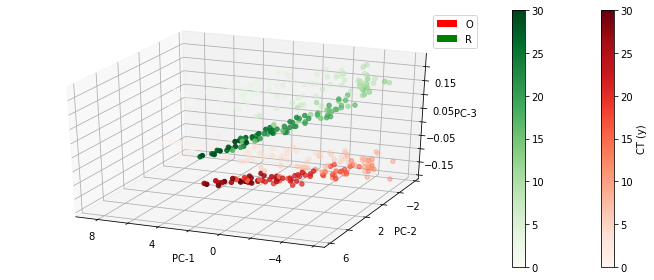

In [26]:
datat3O=np.empty((0,3))
datat3R=np.empty((0,3))

for l,d in zip(labels,datat3):
    if l==0:
        datat3O=np.vstack([datat3O,d])
    else:
        datat3R=np.vstack([datat3R,d])


fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111, projection='3d')
q=ax.scatter(datat3O[:,0],datat3O[:,1],datat3O[:,2],c=fl["CT"]/365, cmap='Reds')
fig.colorbar(q,label="CT (y)",pad=0.00001)
p=ax.scatter(datat3R[:,0],datat3R[:,1],datat3R[:,2],c=fl["CT"]/365, cmap='Greens')
fig.colorbar(p)
ax.legend(recs,leg,loc=1)
ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 != 0]
[l.set_visible(False) for (i,l) in enumerate(ax.yaxis.get_ticklabels()) if i % 2 != 0]
[l.set_visible(False) for (i,l) in enumerate(ax.zaxis.get_ticklabels()) if i % 2 != 0]
ax.azim = 113
ax.elev = 28
plt.tight_layout()

plt.show()

### Only the Eu154 and Cs134 lines

If fresh is set to True, one can see only a line. 

When creating the same plot with CT-based coloring, we see that the variability is still due to CT.

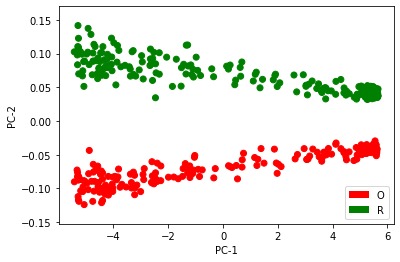

In [19]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Cs134','Eu154'],ratio=False,scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)

pca = decomposition.PCA(n_components=2)
pca.fit(data)
datat = pca.transform(data)


plt.figure()
plt.scatter(datat[:,0],datat[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.show()

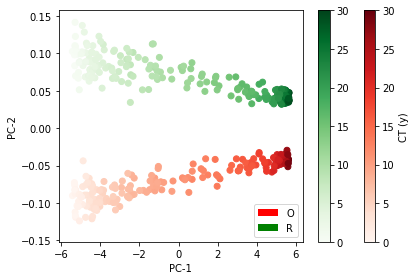

In [20]:
datatO=np.empty((0,2))
datatR=np.empty((0,2))

for l,d in zip(labels,datat):
    if l==0:
        datatO=np.vstack([datatO,d])
    else:
        datatR=np.vstack([datatR,d])
        
plt.figure()
plt.scatter(datatO[:,0],datatO[:,1], c=fl.CT/365, cmap='Reds')
plt.colorbar(pad=0.00001, label='CT (y)')
plt.scatter(datatR[:,0],datatR[:,1], c=fl.CT/365, cmap='Greens')
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.tight_layout()
plt.show()

### Only Eu154 lines

#### Spent fuel attenuation

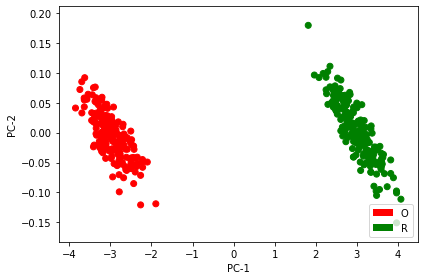

In [23]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Eu154'],ratio=False,scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)

pca = decomposition.PCA(n_components=2)
pca.fit(data)
datat = pca.transform(data)

    
plt.figure()
plt.scatter(datat[:,0],datat[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.tight_layout()
plt.show()

#### Fresh fuel attenuation

We observe single dots in case fresh fuel attenuation is used, and a slight spread due to BU if inventory specific attenuation is used.

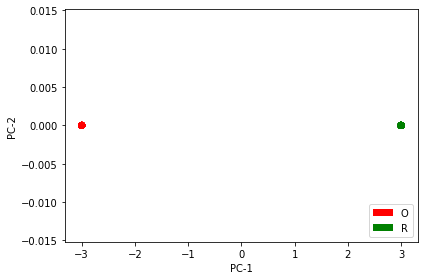

In [27]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Eu154'],ratio=False,scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=True)

pca = decomposition.PCA(n_components=2)
pca.fit(data)
datat = pca.transform(data)

    
plt.figure()
plt.scatter(datat[:,0],datat[:,1], c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.tight_layout()
plt.show()

#### Article plot

Inventory specific attenuation and the points are coloured by BU.

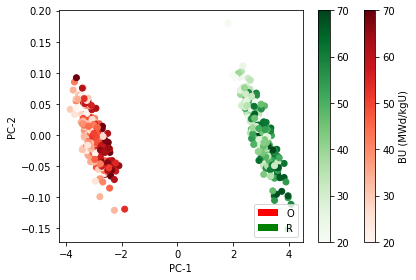

In [24]:
data,labels,energies=prepareX(fuellib=fl, cases=['O','R'],nuclides=['Eu154'],scaling=True,normalization=True,
             encoding={'O':0,'R':1},gefffilestem='outs/geomEff_',fresh=False)

pca = decomposition.PCA(n_components=2)
pca.fit(data)
datat = pca.transform(data)

datatO=np.empty((0,2))
datatR=np.empty((0,2))

for l,d in zip(labels,datat):
    if l==0:
        datatO=np.vstack([datatO,d])
    else:
        datatR=np.vstack([datatR,d])
        
plt.figure()
plt.scatter(datatO[:,0],datatO[:,1], c=fl.BU, cmap='Reds')
plt.colorbar(pad=0.00001, label='BU (MWd/kgU)')
plt.scatter(datatR[:,0],datatR[:,1], c=fl.BU, cmap='Greens')
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(recs,leg,loc=4)
plt.tight_layout()
plt.show()
